In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM

In [3]:
geo = pd.read_csv('../data/daks_processed_with_rf.csv')
geo.head(10)
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth', 'Oil density', 'Oil recovery factor']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [4]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont',
 'Oil density': 'cont',
 'Oil recovery factor': 'cont'}

In [5]:
geo_signs = get_nodes_sign(geo)
geo_signs

{'Gross': 'pos',
 'Netpay': 'pos',
 'Porosity': 'pos',
 'Permeability': 'pos',
 'Depth': 'pos',
 'Oil density': 'pos',
 'Oil recovery factor': 'pos'}

In [6]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [7]:
geo_coded, label_coder = code_categories(geo, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo, 'equal_frequency', columns_for_disc)

In [8]:
bn_full = structure_learning(geo_discrete, 'HC', geo_types, 'K2')
bn_full

  0%|          | 20/1000000 [00:08<114:39:54,  2.42it/s]


{'V': ['Tectonic regime',
  'Period',
  'Lithology',
  'Structural setting',
  'Hydrocarbon type',
  'Gross',
  'Netpay',
  'Porosity',
  'Permeability',
  'Depth',
  'Oil density',
  'Oil recovery factor'],
 'E': [['Period', 'Structural setting'],
  ['Period', 'Porosity'],
  ['Period', 'Netpay'],
  ['Period', 'Depth'],
  ['Period', 'Oil density'],
  ['Lithology', 'Permeability'],
  ['Lithology', 'Period'],
  ['Lithology', 'Depth'],
  ['Lithology', 'Netpay'],
  ['Lithology', 'Oil density'],
  ['Structural setting', 'Tectonic regime'],
  ['Structural setting', 'Netpay'],
  ['Structural setting', 'Oil density'],
  ['Structural setting', 'Depth'],
  ['Hydrocarbon type', 'Oil recovery factor'],
  ['Netpay', 'Gross'],
  ['Porosity', 'Permeability'],
  ['Porosity', 'Depth'],
  ['Permeability', 'Oil recovery factor'],
  ['Permeability', 'Oil density']]}

In [10]:
params = parameter_learning_mix(geo, geo_types, bn_full)
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning:

In [10]:
generate_synthetics(all_bn, geo_signs)

,Hydrocarbon type,Lithology,Tectonic regime,Structural setting,Period,Porosity,Permeability,Depth,Gross,Netpay
0,OIL,DOLOMITE,INVERSION,INVERSION,JURASSIC,22.921707,585.977674,1185.335927,34.231834,16.921484
1,OIL,SANDSTONE,COMPRESSION,FORELAND,NEOGENE,20.586645,495.614504,1322.387408,532.983309,145.137422
2,OIL,SANDSTONE,INVERSION,INVERSION,PALEOGENE,21.326268,589.518085,1257.596995,129.830481,50.686223
3,GAS,SANDSTONE,EXTENSION,RIFT,NEOGENE,35.025609,2273.139458,1175.726317,375.625410,87.900590
4,OIL,SANDSTONE,STRIKE-SLIP,INVERSION,PROTEROZOIC,16.000000,169.061307,1498.835719,60.000000,26.250341
...,...,...,...,...,...,...,...,...,...,...
995,GAS-CONDENSATE,LIMESTONE,INVERSION,INVERSION,NEOGENE,33.111862,360.250354,723.800740,49.200000,23.144037
996,GAS,SANDSTONE,EXTENSION,RIFT,JURASSIC,12.882275,85.829706,2728.593568,178.359102,71.039132
997,GAS-CONDENSATE,SANDSTONE,GRAVITY,DELTA,NEOGENE,11.726161,67.314529,2536.255717,1367.127705,210.095469
998,OIL,SANDSTONE,COMPRESSION,FORELAND,DEVONIAN,14.658683,125.643435,1946.191205,13.667603,7.796618


## Точность восстановления без GMM

In [11]:
acc

{'Tectonic regime': 0.48,
 'Period': 0.37,
 'Lithology': 0.56,
 'Structural setting': 0.56,
 'Hydrocarbon type': 0.75}

In [12]:
rmse

{'Gross': 309.34,
 'Netpay': 80.89,
 'Porosity': 5.77,
 'Permeability': 925.91,
 'Depth': 856.08}

## Точность восстановдения с GMM только на узлах без непрерывных родителей

In [10]:
acc, rmse, real, pred = calculate_acc(all_bn, geo, columns)

In [11]:
rmse

{'Gross': 290.12,
 'Netpay': 81.06,
 'Porosity': 5.75,
 'Permeability': 925.48,
 'Depth': 854.5}

## Точность восстановления с GMM на всех непрерывных узлах

In [11]:
acc, rmse, real, pred = calculate_acc(all_bn, geo, columns)

54


In [12]:
rmse

{'Gross': 289.91,
 'Netpay': 72.99,
 'Porosity': 5.75,
 'Permeability': 815.91,
 'Depth': 836.21}

In [8]:
accuracy_dict = dict()
rmse_dict = dict()
pred_param = [[0 for j in range(geo.shape[0])] for i in range(len(columns))]
real_param = [[0 for j in range(geo.shape[0])] for i in range(len(columns))]
for i in range (geo.shape[0]):
    test = dict(geo.iloc[i,:])
    train_data = geo_discrete.drop(index=i)
    param_train = geo.drop(index=i)
    train_data.reset_index(inplace=True, drop = True)
    param_train.reset_index(inplace=True, drop = True)
    bn = structure_learning(train_data, 'HC', geo_types, 'K2')
    params = parameter_learning(param_train, geo_types, bn)
    save_structure(bn, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    for n, key in enumerate(columns):
        train_dict = copy(test)
        train_dict.pop(key)
        try:
            sample = generate_synthetics(all_bn, geo_signs, evidence=train_dict)
            if sample.shape[0] == 0:
                continue
            else:
                if geo_types[key] == 'disc':
                    dict_top_probs = dict()
                    probs = dict(sample.groupby(key)[key].count() / sample.shape[0])
                    sorted_res = sorted(probs.items(), key=operator.itemgetter(1), reverse=True)
                    pred_param[n][i] = sorted_res[0][0]
                    real_param[n][i] = test[key]
                if geo_types[key] == 'cont':
                    pred_param[n][i] = np.mean(sample[key].values)
                    real_param[n][i] = test[key]
        except:
            continue
for n, key in enumerate(columns):
        if geo_types[key] == 'disc':
            accuracy_dict[key] = round(accuracy_score(real_param[n], pred_param[n]),2)
        if geo_types[key] == 'cont':
            rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False),2)

|          | 11/1000000 [00:01<47:36:34,  5.83it/s]
  0%|          | 13/1000000 [00:02<56:17:13,  4.93it/s]


In [9]:
accuracy_dict

{'Tectonic regime': 0.48,
 'Period': 0.31,
 'Lithology': 0.56,
 'Structural setting': 0.56,
 'Hydrocarbon type': 0.75}

In [10]:
rmse_dict

{'Gross': 351.58,
 'Netpay': 82.64,
 'Porosity': 6.0,
 'Permeability': 971.99,
 'Depth': 927.07}

In [8]:
accuracy_dict = dict()
rmse_dict = dict()
pred_param = [[0 for j in range(geo.shape[0])] for i in range(len(columns))]
real_param = [[0 for j in range(geo.shape[0])] for i in range(len(columns))]
for i in range (geo.shape[0]):
    test = dict(geo.iloc[i,:])
    train_data = geo_discrete.drop(index=i)
    param_train = geo.drop(index=i)
    train_data.reset_index(inplace=True, drop = True)
    param_train.reset_index(inplace=True, drop = True)
    bn = structure_learning(train_data, 'HC', geo_types, 'K2')
    params = parameter_learning_mix(param_train, geo_types, bn)
    save_structure(bn, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    for n, key in enumerate(columns):
        train_dict = copy(test)
        train_dict.pop(key)
        try:
            sample = generate_synthetics(all_bn, geo_signs, evidence=train_dict)
            if sample.shape[0] == 0:
                continue
            else:
                if geo_types[key] == 'disc':
                    dict_top_probs = dict()
                    probs = dict(sample.groupby(key)[key].count() / sample.shape[0])
                    sorted_res = sorted(probs.items(), key=operator.itemgetter(1), reverse=True)
                    pred_param[n][i] = sorted_res[0][0]
                    real_param[n][i] = test[key]
                if geo_types[key] == 'cont':
                    pred_param[n][i] = np.mean(sample[key].values)
                    real_param[n][i] = test[key]
        except:
            continue
for n, key in enumerate(columns):
        if geo_types[key] == 'disc':
            accuracy_dict[key] = round(accuracy_score(real_param[n], pred_param[n]),2)
        if geo_types[key] == 'cont':
            rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False),2)

t/s]
  0%|          | 13/1000000 [00:02<53:48:09,  5.16it/s]


In [9]:
accuracy_dict

{'Tectonic regime': 0.48,
 'Period': 0.3,
 'Lithology': 0.56,
 'Structural setting': 0.56,
 'Hydrocarbon type': 0.75}

In [10]:
rmse_dict

{'Gross': 332.77,
 'Netpay': 82.58,
 'Porosity': 6.0,
 'Permeability': 973.09,
 'Depth': 926.29}

In [35]:
n = n_component(geo, ['Gross'])
n

4

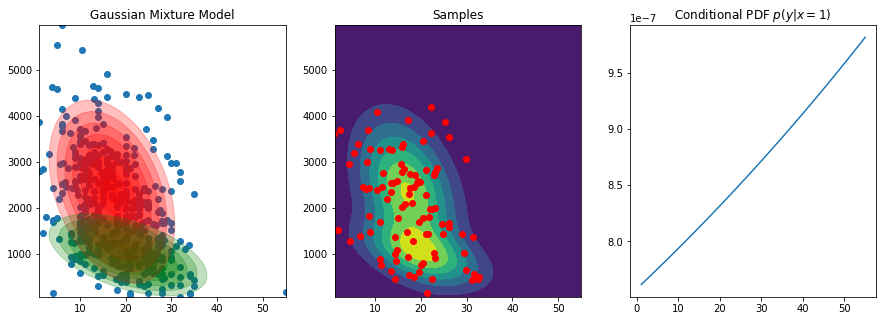

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = geo.shape[0]
n_features = 1
# X = np.ndarray((n_samples, n_features))
# X[:n_samples // 3, :] = random_state.multivariate_normal(
#     [0.0, 1.0], [[0.5, -1.0], [-1.0, 5.0]], size=(n_samples // 3,))
# X[n_samples // 3:-n_samples // 3, :] = random_state.multivariate_normal(
#     [-2.0, -2.0], [[3.0, 1.0], [1.0, 1.0]], size=(n_samples // 3,))
# X[-n_samples // 3:, :] = random_state.multivariate_normal(
#     [3.0, 1.0], [[3.0, -1.0], [-1.0, 1.0]], size=(n_samples // 3,))
X = geo[['Porosity', 'Depth']].values

gmm = GMM(n_components=2, random_state=random_state)
gmm.from_samples(X)
cond = gmm.condition(np.array([0]), np.array([1.0]))
x_min = np.min(geo['Porosity'].values)
x_max = np.max(geo['Porosity'].values)
y_min = np.min(geo['Depth'].values)
y_max = np.max(geo['Depth'].values)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Gaussian Mixture Model")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g"])
plt.scatter(X[:, 0], X[:, 1])

plt.subplot(1, 3, 2)
plt.title("Samples")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
X_test = np.vstack((x.ravel(), y.ravel())).T
p = gmm.to_probability_density(X_test)
p = p.reshape(*x.shape)
plt.contourf(x, y, p)
X_sampled = gmm.sample(100)
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], c="r")

plt.subplot(1, 3, 3)
plt.title("Conditional PDF $p(y | x = 1)$")
X_test = np.linspace(x_min, x_max, 100)
plt.plot(X_test, cond.to_probability_density(X_test[:, np.newaxis]))

plt.show()

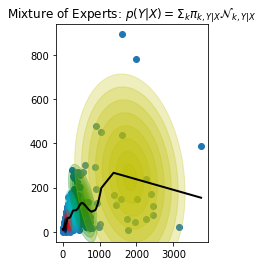

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = geo.shape[0]
# X = np.ndarray((n_samples, 2))
# X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
# X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)
X = geo[['Gross', 'Netpay']].values


X_test = np.array(sorted(geo['Gross'].values))

gmm = GMM(n_components=7, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b", "y", "c", "m", "k"])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()